In [2]:
import torch 
from torch import nn
from neuralop.models import FNO
from torch.optim import Adam

In [3]:
class Branch_net(nn.Module):
    def __init__(self,input,hidden,output):
        super(Branch_net,self).__init__()
            
        self._net = nn.Sequential(
                     nn.Linear(input, hidden),
                     nn.Tanh(),
                     nn.Linear(hidden, hidden),
                     nn.Tanh(),
                     nn.Linear(hidden, output),
                     nn.Tanh(),
                    )
    def forward(self,x):
       
        out=self._net(x)
        return out


class MFNO(nn.Module):
  def __init__(self):
      super(MFNO,self).__init__()
      self.bran_nn = Branch_net(2,50,1)
      self.fno = FNO(n_modes=(1,1),hidden_channels=12,in_channels=1,out_channels=1)

  def forward(self,x,condition):
      #对序列进行fno
      fno_out = self. fno(x) #[4, 3, 640, 300]，640是时间步

      out = self.bran_nn(condition)
      out = out.unsqueeze(-1)
      out = out.unsqueeze(-1)
      #([batch, 3, 1, 300])
      final_out = fno_out*out
      return final_out
  def Get_brann(self,Simulate,ini_data):
      fno_out = self. fno(ini_data) #[4, 3, 640, 300]，640是时间步
      brann = Simulate/fno_out
      return brann

      
      

In [38]:
# Instantiate the model
model = MFNO()

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = MFNO()  # 假设你已经定义和初始化了你的模型
print("Total number of trainable parameters:", count_parameters(model))


Total number of trainable parameters: 11708


In [5]:
initial_condition =torch.rand((1,1,30,30))
real_condition = torch.rand((1,2))
a=model(initial_condition,real_condition)

In [6]:
bran=model.Get_brann(a,initial_condition).detach()

In [7]:
def freeze_all(model):
    for param in model.parameters():
        param.requires_grad = True


In [11]:
freeze_all(model)

In [8]:
def gradient_objective_function(model, inputs, target):
    inputs.requires_grad_(True)
    outputs = model.bran_nn(inputs)

    t=target[0,0,0,1] # 因为重复
    loss = (outputs - t).pow(2).mean()  # 使用MSE作为损失函数
    
    loss.backward()
    grad=inputs.grad.data
    
    return grad, loss.item(),outputs.item()

In [10]:
import matplotlib.colors as mcolors

In [11]:
import matplotlib.pyplot as plt
class GradientInformedPSO:
    def __init__(self, model, gradient_func, target, num_particles=5, dims=2, epochs=2, lr=0.0001,w=0.5):
        self.model = model
        self.gradient_func = gradient_func
        self.target = target
        self.num_particles = num_particles
        self.dims = dims
        self.epochs = epochs
        self.lr = lr
        self.particles = torch.rand(num_particles, dims)*100   # 初始化粒子位置
        self.velocities = torch.zeros(num_particles, dims)  # 初始化粒子速度
        self.best_positions = torch.clone(self.particles)  # 个体最佳位置
        self.best_scores = torch.full((num_particles,), float('inf'))  # 个体最佳分数
        self.global_best_position = None
        self.global_best_score = float('inf')
        self.w = 0.5
               # 历史记录
        self.particles_history = []
        self.velocities_history = []
        self.global_best_score_history = []

    def optimize(self):
        for epoch in range(self.epochs):
         
            for i in range(self.num_particles):
                gradient, score,out_put = self.gradient_func(self.model, self.particles[i].unsqueeze(0), self.target)
                       # 历史记录
                self.particles_history.append(self.particles.clone())
                self.velocities_history.append(self.velocities.clone())
                self.global_best_score_history.append(self.global_best_score)
                if score < self.best_scores[i]:
                    self.best_scores[i] = score
                    self.best_positions[i] = self.particles[i]

                # 更新全局最佳位置
                if score < self.global_best_score:
                    self.global_best_score = score
                    self.global_best_position = self.particles[i]
                
                # 更新速度和位置
               
                r1, r2 = torch.rand(2)  # 随机数
                c1, c2 = 1.49445, 1.49445  # 学习因子，通常为1.49445
                self.velocities[i] = (
                    self.w * self.velocities[i] +
                    c1 * r1 * (self.best_positions[i] - self.particles[i]) +
                    c2 * r2 * (self.global_best_position - self.particles[i]) +
                    self.lr * gradient.squeeze()
                )



                self.particles[i] -= self.velocities[i]  # 更新位置

            print("epoch=", epoch,self.global_best_position,self.global_best_score)
            print("brann_out",out_put)

        return self.global_best_position.cpu().numpy(), self.global_best_score
   
    
    def visualize(self):
        import matplotlib.pyplot as plt
        import matplotlib.colors as mcolors
        fig, ax = plt.subplots(figsize=(6, 5))
        cmap = plt.cm.viridis  # Choose a colormap
        
        # Normalize the epoch numbers for color mapping
        norm = mcolors.Normalize(vmin=0, vmax=self.epochs)

        # Plot the trajectories of each particle
        for particle_index in range(self.num_particles):
            # Generate a color for each particle inside the loop where it's used
            particle_color = cmap(norm(particle_index / self.num_particles))
            
        for epoch in range(1, self.epochs):
            # Previous and current position
            prev_pos = self.particles_history[epoch-1][particle_index].cpu().numpy()
            curr_pos = self.particles_history[epoch][particle_index].cpu().numpy()
            
            # Draw the trajectory segment
            ax.plot([prev_pos[0], curr_pos[0]], [prev_pos[1], curr_pos[1]], color=particle_color)

        # Draw the velocity vectors for the last epoch
        positions = self.particles_history[-1].cpu().numpy()
        velocities = self.velocities_history[-1].cpu().numpy()
        for i in range(self.num_particles):
            # Fix: Correctly use the color for each particle inside the loop
            particle_color = cmap(norm(i / self.num_particles))
            ax.quiver(positions[i, 0], positions[i, 1], velocities[i, 0], velocities[i, 1], color=particle_color, angles='xy', scale_units='xy', scale=1, alpha=0.5)

 
        plt.show()
      
     

     

# 目标值
target_output = bran

# 创建PSO优化器实例
pso_optimizer = GradientInformedPSO(model, gradient_objective_function, target_output, epochs=2)

# 执行优化
best_position, best_score = pso_optimizer.optimize()
print(f"Best position (a, b): {best_position}")
print(f"Best score (distance from target): {best_score}")
#pso_optimizer.visualize()

epoch= 0 tensor([24.9000, 47.3158]) 3.855021350318566e-05
brann_out 0.06961295753717422
epoch= 1 tensor([24.9000, 47.3158]) 3.855021350318566e-05
brann_out 0.06257529556751251
Best position (a, b): [24.899977 47.3158  ]
Best score (distance from target): 3.855021350318566e-05


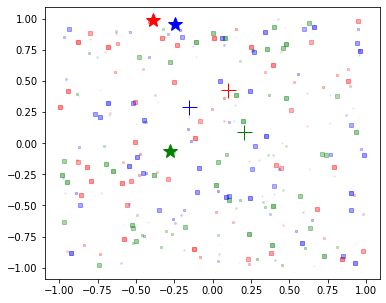

In [211]:
# Adjusting the code to have three different colors for each particle, starting with circles
# and ending with stars. The trajectory color starts light and ends dark near the star.

# Create the figure and axis again
fig, ax = plt.subplots(figsize=(6, 5))

# Define colors for the particles
colors = ['red', 'green', 'blue']

# Plot trajectories with increasing line width and color gradient
for particle_index, color in enumerate(colors):
    for epoch in range(1, epochs):
        prev_pos = particles_history[epoch-1][particle_index]
        curr_pos = particles_history[epoch][particle_index]
        #line_width =  (epoch / epochs)   # Line width increases over time
        # Lighten the color as the epoch decreases, darken as it increases
        color_intensity = 0.5*epoch / epochs   # Color darkens over time
   
        ax.plot(curr_pos[0], curr_pos[1], marker='s', color=color, markersize=10*color_intensity,alpha= color_intensity)

# Mark starting positions with a circle
for particle_index, color in enumerate(colors):
    start_pos = particles_history[0][particle_index]

    ax.plot(start_pos[0], start_pos[1], marker='+', color=color, markersize=15,alpha= 1)

# Mark ending positions with a star
for particle_index, color in enumerate(colors):
    end_pos = particles_history[-1][particle_index]
    ax.plot(end_pos[0], end_pos[1], marker='*', color=color, markersize=15)

# Setting aspect ratio to equal for correct sdisplay of markers


# Show the plot
plt.show()


In [14]:
import numpy as np
from sko.PSO import PSO


def demo_func(x):
    x1, x2 = x
    return -20 * np.exp(-0.2 * np.sqrt(0.5 * (x1 ** 2 + x2 ** 2))) - np.exp(
        0.5 * (np.cos(2 * np.pi * x1) + np.cos(2 * np.pi * x2))) + 20 + np.e


constraint_ueq = (
    lambda x: (x[0] - 1) ** 2 + (x[1] - 0) ** 2 - 0.5 ** 2
    ,
)

max_iter = 50
pso = PSO(func=demo_func, n_dim=2, pop=40, max_iter=max_iter, lb=[-2, -2], ub=[2, 2]
          , constraint_ueq=constraint_ueq)
pso.record_mode = True
pso.run()
print('best_x is ', pso.gbest_x, 'best_y is', pso.gbest_y)

# %% Now Plot the animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

record_value = pso.record_value
X_list, V_list = record_value['X'], record_value['V']

fig, ax = plt.subplots(1, 1)
ax.set_title('title', loc='center')
line = ax.plot([], [], 'b.')

X_grid, Y_grid = np.meshgrid(np.linspace(-2.0, 2.0, 40), np.linspace(-2.0, 2.0, 40))
Z_grid = demo_func((X_grid, Y_grid))
ax.contour(X_grid, Y_grid, Z_grid, 30)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

t = np.linspace(0, 2 * np.pi, 40)
ax.plot(0.5 * np.cos(t) + 1, 0.5 * np.sin(t), color='r')

plt.ion()
p = plt.show()


def update_scatter(frame):
    i, j = frame // 10, frame % 10
    ax.set_title('iter = ' + str(i))
    X_tmp = X_list[i] + V_list[i] * j / 10.0
    plt.setp(line, 'xdata', X_tmp[:, 0], 'ydata', X_tmp[:, 1])
    return line


ani = FuncAnimation(fig, update_scatter, blit=True, interval=25, frames=max_iter * 10)
plt.show()

ani.save('pso.gif', writer='pillow')

KeyboardInterrupt: 

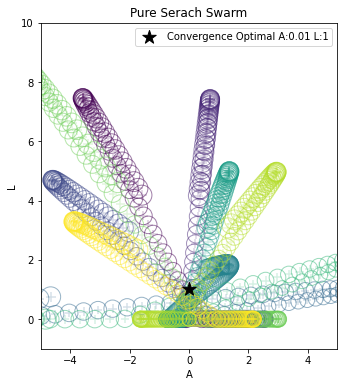

In [96]:
import numpy as np
import matplotlib.pyplot as plt

def nonlinear_path(start, end, steps, curve_intensity=0.5):
   
    t = np.linspace(0, 1, steps)
    # 计算非线性路径
    path = (2*np.sin(2 * np.pi * t) - t)[:, np.newaxis] * start + t[:, np.newaxis] * end + np.sin(2 * np.pi * t)[:, np.newaxis] * curve_intensity * (end - start)
    # 确保y坐标不小于0
    path[:, 1] = np.clip(path[:, 1], 0, None)  # 将y坐标的下限设为0
    return path
# Setup the figure and axes
fig, ax = plt.subplots(figsize=(12,6))

# Generate random star positions
# 设置随机种子以保证结果的可重复性
np.random.seed(42)

# 生成10个星星的位置
# x坐标几乎都是在0.1附近，可以通过给0.1加上一个非常小的随机扰动来实现
x_coords = 0.1 + np.random.randn(10) * 3  # 使用正态分布进行小范围扰动
y_coords = np.random.rand(10) * 10 - 5  # y坐标在[-5, 5]范围内随机

# 组合x和y坐标
stars = np.column_stack((x_coords, y_coords))

# Generate a unique color for each star and create a colormap for each
colors = plt.cm.viridis(np.linspace(0, 1, 10))  # Use a color map to get distinct colors

# Define the convergence point (shape of a black star)
convergence_point = np.array([0, 1])

# Generate and draw paths
for idx, star in enumerate(stars):
    path = nonlinear_path(star, convergence_point, 100, 0.5)
    color = colors[idx]  # Pick color for this star
    # Create size gradient for markers
    sizes = np.linspace(50, 100, len(path))
    # Draw path with size gradient using hollow circles and small plus markers at the center
    ax.scatter(path[:, 0], path[:, 1], facecolors='none', edgecolors=color, s=sizes*4, marker='o', alpha=0.5)  # Draw hollow circles
    ax.scatter(path[:, 0], path[:, 1], color=color, s=sizes * 1, marker='+', alpha=0.2)  # Draw small pluses

# Draw the convergence star (a large black star)
ax.scatter([0], [1], s=200, c='black', marker='*', label='Convergence Optimal A:0.01 L:1')

# Set the aspect of the plot to be equal and set limits for clarity
ax.set_aspect('equal')
ax.set_xlim(-5,5)
ax.set_ylim(-1,10)
ax.legend()
ax.set_xlabel("A")
ax.set_ylabel("L")
plt.title("Pure Serach Swarm")
plt.savefig("Clip 0",dpi=300)


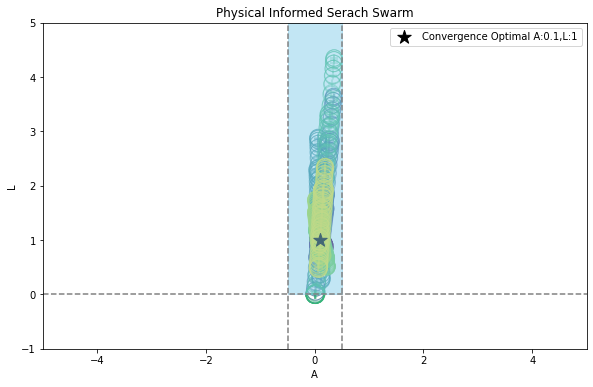

In [109]:
import numpy as np
import matplotlib.pyplot as plt

def nonlinear_path(start, end, steps, curve_intensity=0.5):
    t = np.linspace(0, 1, steps)
    # 增加正弦函数的影响，使路径更加非线性
    path = (1 - t)[:, np.newaxis] * start + t[:, np.newaxis] * end + curve_intensity * 2*np.sin(4 * np.pi * t)[:, np.newaxis] * (end - start)
    # 确保y坐标不小于0
    path[:, 1] = np.clip(path[:, 1], 0, None)  # 将y坐标的下限设为0
    return path

# Setup the figure and axes
fig, ax = plt.subplots(figsize=(12,6))

# 设置随机种子
np.random.seed(42)

# 生成星星的x坐标和y坐标
x_coords = 0.1 + np.random.randn(10) * 0.1
y_coords = np.random.rand(10) * 5  # 使y坐标范围为[0, 5]，确保从非负值开始

# 组合x和y坐标
stars = np.column_stack((x_coords, y_coords))

# 为每个星星生成唯一的颜色
colors = plt.cm.viridis(np.linspace(0, 1, 10))

# 定义收敛点（现在收敛到 x = 0.1）
convergence_point = np.array([0.1, 1])

# 生成并绘制路径
for idx, star in enumerate(stars):
    path = nonlinear_path(star, convergence_point, 100, 0.5)
    color = colors[idx]
    sizes = np.linspace(50, 100, len(path))
    ax.scatter(path[:, 0], path[:, 1], facecolors='none', edgecolors=color, s=sizes*4, marker='o', alpha=0.5)
    ax.scatter(path[:, 0], path[:, 1], color=color, s=sizes, marker='+', alpha=0.2)

# 绘制收敛点
ax.scatter([0.1], [1], s=200, c='black', marker='*', label='Convergence Optimal A:0.1,L:1')
ax.legend()
# 设置图形属性
ax.set_aspect('equal')
ax.set_xlim(-5, 5)
ax.set_ylim(-1, 5)
ax.axhline(y=0, color='gray', linestyle='--')
# 添加垂直线，在x=5处，可以用来标示特定的x值
ax.axvline(x=-0.5, color='gray', linestyle='--')
ax.axvline(x=0.5, color='gray', linestyle='--')
# 在 x = -0.5 到 x = 0.5 之间填充颜色
ax.fill_between(x=[-0.5, 0.5], y1=0, y2=5, color='skyblue', alpha=0.5)
ax.set_xlabel("A")
ax.set_ylabel("L")
plt.title("Physical Informed Serach Swarm")
plt.savefig("PI+Clip 0",dpi=300)


In [15]:
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from sko.PSO import PSO

# Objective function
def demo_func(x):
    x1, x2 = x
    return -20 * np.exp(-0.2 * np.sqrt(0.5 * (x1 ** 2 + x2 ** 2))) - np.exp(
        0.5 * (np.cos(2 * np.pi * x1) + np.cos(2 * np.pi * x2))) + 20 + np.e

# Unequal constraint
constraint_ueq = (
    lambda x: (x[0] - 1) ** 2 + (x[1] - 0) ** 2 - 0.5 ** 2,
)

# Initialize PSO
max_iter = 50
pso = PSO(func=demo_func, n_dim=2, pop=40, max_iter=max_iter, lb=[-2, -2], ub=[2, 2],
          constraint_ueq=constraint_ueq)
pso.record_mode = True
pso.run()

# Prepare the figure
fig, ax = plt.subplots(1, 1)
ax.set_title('PSO optimization process', loc='center')

# Contour plot of the function
X_grid, Y_grid = np.meshgrid(np.linspace(-2.0, 2.0, 40), np.linspace(-2.0, 2.0, 40))
Z_grid = demo_func((X_grid, Y_grid))
contour = ax.contour(X_grid, Y_grid, Z_grid, 30)
ax.clabel(contour, inline=True, fontsize=8)

# Circle constraint
t = np.linspace(0, 2 * np.pi, 40)
ax.plot(0.5 * np.cos(t) + 1, 0.5 * np.sin(t), color='r')

# Set axis limits
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

# Create a scatter plot which will be updated during the animation
scat = ax.scatter([], [], c='b', alpha=0.6)

# Function to update the scatter plot each frame
def update_scatter(frame):
    # Get particle positions for the current frame
    X = pso.record_value['X'][frame]
    V = pso.record_value['V'][frame]

    # Update scatter plot data
    scat.set_offsets(X)
    
    # Change alpha based on the iteration number to show the trail
    alpha_values = np.linspace(0.1, 0.9, num=max_iter)
    scat.set_alpha(alpha_values[frame])
    
    # Update title with iteration number
    ax.set_title(f'PSO optimization process - Iteration {frame+1}')
    
    return scat,

# Create the animation
ani = FuncAnimation(fig, update_scatter, frames=max_iter, blit=False, interval=200)


# Note: We won't save the animation as a file, just display it inline
# If you want to save it,


ModuleNotFoundError: No module named 'sko'

In [7]:
# [Mamba: Linear-Time Sequence Modeling with Selective State Spaces](https://arxiv.org/abs/2312.00752)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from einops import rearrange, repeat
from tqdm import tqdm

import math
import os
import urllib.request
from zipfile import ZipFile




torch.autograd.set_detect_anomaly(True)
debugging_is_on = 0

def print_tensor_info(tensor_name, tensor):
    # Check if tensor is floating point, and convert if necessary
    tensor_float = tensor.float() if not tensor.is_floating_point() else tensor

    # Gather the information
    info = {
        "shape": tuple(tensor.shape),
        "min/max": (tensor.min().item(), tensor.max().item()),
        "mean": tensor_float.mean().item(),
        "std": tensor_float.std().item()
    }

    # Print the default representation and the extra information
    print(f"{tensor_name} = {tensor}")
    for key, value in info.items():
        print(f"{key}: {value}")



USE_MAMBA = 1
USE_TRANSFORMER = ~USE_MAMBA
DIFFERENT_H_STATES_RECURRENT_UPDATE_MECHANISM = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# User hyperparameters
d_model = 16
state_size = 64  # Example state size
seq_len = 100  # Example sequence length
batch_size = 128  # Example batch size


class S6(nn.Module):
    def __init__(self, seq_len, d_model, state_size, device):
        super(S6, self).__init__()

        self.fc1 = nn.Linear(d_model, d_model, device=device)
        self.fc2 = nn.Linear(d_model, state_size, device=device)
        self.fc3 = nn.Linear(d_model, state_size, device=device)

        self.seq_len = seq_len
        self.d_model = d_model
        self.state_size = state_size

        #self.A = nn.Parameter(torch.ones(d_model, state_size, device=device))
        #self.A = nn.Parameter(F.normalize(torch.ones(d_model, state_size, device=device), p=2, dim=-1))
        #nn.init.xavier_uniform_(self.A)

        # S4D real initialization, MAMBA removed imaginary portions for S4D-Inv and S4D-Lin initialization schemes
        # described in [On the Parameterization and Initialization of Diagonal State Space Models](https://arxiv.org/abs/2206.11893)
        # https://github.com/state-spaces/mamba/blob/fb7b5310fa865dbd62aa059b1e26f2b431363e2a/mamba_ssm/modules/mamba_simple.py#L103-L108C23
        A = repeat(
            torch.arange(1, state_size + 1, dtype=torch.float32, device=device),
            "n -> d n",
            d=d_model,
        ).contiguous()

        A_log = torch.log(A)  # For numerical stability during training process
        self.A_log = nn.Parameter(A_log)
        self.A_log._no_weight_decay = True

        self.A = torch.zeros_like(self.A_log)
        self.B = torch.zeros(batch_size, self.seq_len, self.state_size, device=device)
        self.C = torch.zeros(batch_size, self.seq_len, self.state_size, device=device)

        #self.delta = torch.zeros(batch_size, self.seq_len, self.d_model, device=device)
        # Initialize delta parameter using a uniform distribution and apply the inverse softplus
        uniform_distribution = torch.distributions.Uniform(0.001, 0.1)
        # Sample from the uniform distribution and then apply the inverse softplus
        self.delta = self.inverse_softplus(uniform_distribution.sample((batch_size, self.seq_len, self.d_model)))

        self.dA = torch.zeros(batch_size, self.seq_len, self.d_model, self.state_size, device=device)
        self.dB = torch.zeros(batch_size, self.seq_len, self.d_model, self.state_size, device=device)

        # h should have dimensions [batch_size, seq_len, d_model, state_size]
        self.h = torch.zeros(batch_size, self.seq_len, self.d_model, self.state_size, device=device)
        self.y = torch.zeros(batch_size, self.seq_len, self.d_model, device=device)


    def inverse_softplus(self, y):
        return torch.log(torch.exp(y) - 1)

    def discretization(self):
        # discretization function is defined based on the MAMBA paper's description using ZOH on page 28
        # in Section C : Mechanics on Selective SSMs
        # See also "Zero-order hold discretization" maths proof inside https://studywolf.wordpress.com/tag/zero-order-hold/
        """
        Here is an explanation of the mathematical rationale for the formulation of Δt used in Mamba:

        The key idea is that Δt controls the discretization rate of the continuous SSM dynamics. By making Δt input-dependent, it introduces selectivity into the discrete transition matrices.

        Specifically, in Mamba they parameterize Δt as:

        Δt = τΔ(Parameter + sΔ(xt))

        Where:

        - Parameter is a learned scalar parameter that controls the baseline discretization rate
        - sΔ(xt) is a projection that makes Δt input-dependent by computing a value based on xt
        - τΔ(x) = softplus(x) transforms the result to be positive through the softplus nonlinearity

        The rationale for this formulation is:
        - Parameter provides a reasonable default discretization rate
        - sΔ(xt) injects input-dependence through the projection
        - softplus ensures Δt is positive as required to be a valid timestep
        - The projection sΔ allows the model to learn to modulate Δt based on the input xt
        - This modulation creates selectivity in how rapidly or slowly the states update

        So in summary, the learned input-dependent projection allows Δt, and thus the discrete dynamics, to become selective. The softplus and scalar parameter provide useful inductive biases on top of this flexibility.

        The end result is discrete transition matrices that are selective on the input, enabling powerful sequence modeling capabilities.

        Credit: Claude2 AI chatbot
        """

        # For numerical stability during training process
        self.A = -torch.exp(self.A_log.float())  # (d_model, state_size)

        #print(f"self.A.shape = {self.A.shape}")
        #print(f"self.B.shape = {self.B.shape}")
        #print(f"self.delta.shape = {self.delta.shape}")

        # inverse() only supports square matrix
        #dB = torch.matmul(torch.inverse(A * delta), torch.matmul(dA - torch.eye(A.shape[0]), B))
        self.dB = torch.einsum("bld,bln->bldn", self.delta, self.B)

        # https://github.com/state-spaces/mamba/blob/0131c1e94a46fc9f70bcfc9d57962963bb2f0b9e/mamba_ssm/modules/mamba_simple.py#L240
        #dA = torch.matrix_exp(A * delta)  # matrix_exp() only supports square matrix
        self.dA = torch.exp(torch.einsum("bld,dn->bldn", self.delta, self.A))
        #print(f"self.dA.shape = {self.dA.shape}")
        #print(f"self.dA.requires_grad = {self.dA.requires_grad}")

        return self.dA, self.dB

    def forward(self, x):
        # Refer to Algorithm 2 in the MAMBA paper
        self.B = self.fc2(x)
        self.C = self.fc3(x)

        # "a large ∆ resets the state `h` and focuses on the current input `x`,
        # while a small ∆ persists the state and ignores the current input."
        self.delta = F.softplus(self.fc1(x))

        # Uses ZOH as in MAMBA, Hungry Hippo still uses bilinear transform for discretization
        self.discretization()

        if DIFFERENT_H_STATES_RECURRENT_UPDATE_MECHANISM:  # this will trigger in-place runtime error if without using `h_new`
            #print(f"self.dA = {self.dA}, self.dB = {self.dB}")
            #print(f"self.dA.shape = {self.dA.shape}")
            #print(f"self.dB.shape = {self.dB.shape}")
            #print(f"x.shape = {x.shape}")
            #print(f"self.h.shape = {self.h.shape}")
            #print(f"self.C.shape = {self.C.shape}")

            global current_batch_size
            current_batch_size = x.shape[0]

            if self.h.shape[0] != current_batch_size:
                #print("Adjusting h_new for the different batch size of input data `x`")
                different_batch_size = True

                # Resize self.h to match the current batch size
                h_new =  torch.einsum('bldn,bldn->bldn', self.dA, self.h[:current_batch_size, ...]) + rearrange(x, "b l d -> b l d 1") * self.dB

            else:
                different_batch_size = False
                h_new =  torch.einsum('bldn,bldn->bldn', self.dA, self.h) + rearrange(x, "b l d -> b l d 1") * self.dB

            # y needs to have a shape of [batch_size, seq_len, d_model]
            self.y = torch.einsum('bln,bldn->bld', self.C, h_new)

            # Update self.h with the detached state of h_new
            # Only do this if retaining gradients for self.h is not necessary for backprop
            # Otherwise, store h_new in a temporary list and update self.h after the loop
            global temp_buffer
            temp_buffer = h_new.detach().clone() if not self.h.requires_grad else h_new.clone()
            #print(f"temp_buffer.shape = {temp_buffer.shape}")

            #print(f"self.y = {self.y}")
            #print(f"self.dA.requires_grad = {self.dA.requires_grad}")
            #print(f"self.dB.requires_grad = {self.dB.requires_grad}")
            #print(f"self.C.requires_grad = {self.C.requires_grad}")
            #print(f"self.h.requires_grad = {self.h.requires_grad}")
            #print(f"self.y.requires_grad = {self.y.requires_grad}")

            return self.y

        else:  # this will not trigger in-place runtime error
            # h should have dimensions [batch_size, seq_len, d_model, state_size]
            h = torch.zeros(x.size(0), self.seq_len, self.d_model, self.state_size, device=x.device)
            y = torch.zeros_like(x)

            h =  torch.einsum('bldn,bldn->bldn', self.dA, h) + rearrange(x, "b l d -> b l d 1") * self.dB

            # y needs to have a shape of [batch_size, seq_len, d_model]
            y = torch.einsum('bln,bldn->bld', self.C, h)

            return y

class MambaBlock(nn.Module):
    def __init__(self, seq_len, d_model, state_size, device):
        super(MambaBlock, self).__init__()

        self.inp_proj = nn.Linear(d_model, 2*d_model, device=device)
        self.out_proj = nn.Linear(2*d_model, d_model, device=device)

        # For residual skip connection
        self.D = nn.Linear(d_model, 2*d_model, device=device)

        # Set _no_weight_decay attribute on bias
        self.out_proj.bias._no_weight_decay = True

        # Initialize bias to a small constant value
        nn.init.constant_(self.out_proj.bias, 1.0)

        self.S6 = S6(seq_len, 2*d_model, state_size, device)

        # Add 1D convolution with kernel size 3
        self.conv = nn.Conv1d(seq_len, seq_len, kernel_size=3, padding=1, device=device)

        # rmsnorm
        self.norm = RMSNorm(d_model, device=device)


    def forward(self, x, attention_mask=None):

        if attention_mask is not None:
            # Apply the attention mask
            #print(f"Inside Mamba_block, x.shape = {x.shape}, attention_mask.shape = {attention_mask.shape}")
            x = x * attention_mask.unsqueeze(-1)

        """
        x_proj.shape = torch.Size([batch_size, seq_len, 2*d_model])
        x_conv.shape = torch.Size([batch_size, seq_len, 2*d_model])
        x_conv_act.shape = torch.Size([batch_size, seq_len, 2*d_model])
        """
        # Refer to Figure 3 in the MAMBA paper

        x = self.norm(x)

        x_proj = self.inp_proj(x)
        #print(f"x_proj.shape = {x_proj.shape}")

        # Add 1D convolution with kernel size 3
        x_conv = self.conv(x_proj)

        # Create a triangular mask of the same shape as the input sequence
        mask = torch.tril(torch.ones(seq_len, 2*d_model, device=device))

        # Add batch dimension with unsqueeze(0) -> (1, seq_len, seq_len)
        # Repeat batch dim to match x_conv batches with .repeat()
        current_batch_size = x.shape[0]
        mask = mask.repeat(current_batch_size, 1, 1)

        # Apply causal mask to zero out the masked regions
        x_conv = x_conv * mask
        #print(f"x_conv.shape = {x_conv.shape}")

        x_conv_act = F.silu(x_conv)  # Swish activation can be implemented as x * sigmoid(x)
        #print(f"x_conv_act.shape = {x_conv_act.shape}")

        x_ssm = self.S6(x_conv_act)
        #print(f"x_ssm.shape = {x_ssm.shape}")

        # residual skip connection with nonlinearity introduced by multiplication
        x_residual = F.silu(self.D(x))
        #print(f"x_residual.shape = {x_residual.shape}")
        x_combined = x_ssm * x_residual
        #print(f"x_combined.shape = {x_combined.shape}")

        x_out = self.out_proj(x_combined)
        #print(f"x_out.shape = {x_out.shape}")

        return x_out


class Mamba(nn.Module):
    def __init__(self, seq_len, d_model, state_size, vocab_size, device):
        super(Mamba, self).__init__()

        if vocab_size is None:
            vocab_size = d_model

        # Linear layer versus Embedding layer
        # Functionality: nn.Linear() is a general-purpose linear transformation layer, while
        #                nn.Embedding() is specifically designed for embedding lookups.
        # Input Type: nn.Linear() accepts continuous input data, whereas
        #             nn.Embedding() expects discrete input data (typically indices).
        # nn.Linear() is used for transforming data linearly, while
        # nn.Embedding() is used for mapping discrete data (like words or item IDs) to vectors in a continuous space.
        # embedding_dim is the size of the embedding vectors (MAMBA model's D)
        # This will change incoming input from shape [B, L] to [B, L, D]
        self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model, device=device)

        # All three Mamba blocks are operating at a downsized dimension of `d_model` instead of `vocab_size`
        self.mamba_block1 = MambaBlock(seq_len, d_model, state_size, device)
        self.mamba_block2 = MambaBlock(seq_len, d_model, state_size, device)
        self.mamba_block3 = MambaBlock(seq_len, d_model, state_size, device)

        self.up_proj = nn.Linear(d_model, vocab_size, device=device)

    def forward(self, x, attention_mask=None):
        #print(f"Before nn.embedding(), x.shape = {x.shape}")
        x = self.embedding_layer(x.type(torch.long)).type(torch.float32)
        #print(f"After nn.embedding(), x.shape = {x.shape}")

        x = self.mamba_block1(x, attention_mask)
        x = self.mamba_block2(x, attention_mask)
        x = self.mamba_block3(x, attention_mask)

        x = self.up_proj(x)

        return x


class RMSNorm(nn.Module):
    def __init__(self,
                 d_model: int,
                 eps: float = 1e-5,
                 device: str ='cuda'):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model, device=device))


    def forward(self, x):
        output = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight

        return output


# Example usage:
# Create a random input tensor
if USE_MAMBA:
    x = torch.rand(batch_size, seq_len, device=device)
    # Create the Mamba model
    mamba = Mamba(seq_len, d_model, state_size, None, device)

    # Forward pass
    test_output = mamba(x.type(torch.long))
    print(f"test_output.shape = {test_output.shape}")  # Should be [batch_size, seq_len, d_model]







test_output.shape = torch.Size([128, 100, 16])


In [8]:
# 函数来计算模型的总参数数量
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

# 调用函数
total_params = count_parameters(mamba)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 117708
